### Workflow with Orchestration

Implements the following design pattern:
* https://langchain-ai.github.io/langgraph/tutorials/workflows/#orchestrator-worker
* in this version the json schema is derived (using: model_json_schema())

In [1]:
from typing_extensions import TypedDict
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown

from oci_models import create_model_for_routing, create_model_for_answer_directly

# added to integrate with APM
from abc_tracing import BaseNode
from py_zipkin import Encoding
from py_zipkin.zipkin import zipkin_span
from transport import http_transport

In [2]:
# models used in the rest of the code
llm = create_model_for_routing()
llm_ad = create_model_for_answer_directly()


# Schema for structured output to use in planning
class Section(BaseModel):
    """
    section
    """

    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    """
    sections
    """

    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Graph state
class State(TypedDict):
    """
    workflow state
    """

    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    """
    workflow state
    """

    section: Section
    completed_sections: Annotated[list, operator.add]


# Augment the LLM with schema for structured output
json_schema = Sections.model_json_schema()

planner = llm.with_structured_output(json_schema)

In [3]:
# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    for i, s in enumerate(state["sections"]):
        print(
            f"{i+1} Calling llm for section {s['name']}\nDescription: {s['description']}"
        )

    return [Send("worker", {"section": s}) for s in state["sections"]]

In [4]:
#
# This one shows how to use a runnable
#
class Orchestrator(BaseNode):
    #
    # we need to implement only this method
    #
    def _run_impl(self, state):
        """Orchestrator: generates a plan for the report"""

        # Generate queries
        report_sections = planner.invoke(
            [
                HumanMessage(
                    content=f"""Generate a plan for the report.\n
                Follow strictly the following JSON SCHEMA: {str(json_schema)}
                Here is the report topic: {state['topic']}
                """
                ),
            ]
        )

        return {"sections": report_sections["sections"]}


class Worker(BaseNode):
    #
    # we need to implement only this method
    #
    def _run_impl(self, state):
        """Subclasses must implement this method."""

        # Generate section
        # we're using another model
        section = llm_ad.invoke(
            [
                SystemMessage(
                    content="""Write a report section following the provided name and description. 
                    Include no preamble for each section. Use markdown formatting."""
                ),
                HumanMessage(
                    content=f"Here is the section name: {state['section']['name']} and description: {state['section']['description']}"
                ),
            ]
        )

        # Write the updated section to completed sections
        return {"completed_sections": [section.content]}


class Synthesizer(BaseNode):
    #
    # we need to implement only this method
    #
    def _run_impl(self, state):
        """Subclasses must implement this method."""
        # List of completed sections
        completed_sections = state["completed_sections"]

        # Format completed section to str to use as context for final sections
        completed_report_sections = "\n\n---\n\n".join(completed_sections)

        return {"final_report": completed_report_sections}


# instantiate the classes
orchestrator = Orchestrator()
synthesizer = Synthesizer()
worker = Worker()

In [5]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("worker", worker)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["worker"]
)
orchestrator_worker_builder.add_edge("worker", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

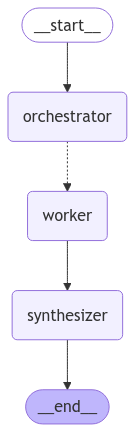

In [6]:
# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [7]:
#
# Helper functions
#
def invoke_agent(user_request: str):
    """
    start the trace
    """
    with zipkin_span(
        service_name="agents01",
        span_name="trace01",
        transport_handler=http_transport,
        encoding=Encoding.V2_JSON,
        sample_rate=100,  # this is optional and can be used to set custom sample rates
    ):
        # here we invoke the agent
        state = orchestrator_worker.invoke({"topic": user_request})

    return state


def print_final_report(state):
    display(Markdown(state["final_report"]))

In [8]:
# Invoke
state = invoke_agent("Create a report on AI Agents")

1 Calling llm for section Introduction
Description: An overview of the report and its purpose.
2 Calling llm for section What are AI Agents?
Description: A definition of AI Agents and their role in AI.
3 Calling llm for section Types of AI Agents
Description: A discussion of the different types of AI Agents, including their capabilities and applications.
4 Calling llm for section Applications of AI Agents
Description: An exploration of the various industries and use cases where AI Agents are employed.
5 Calling llm for section Challenges and Ethical Considerations
Description: An examination of the challenges and ethical dilemmas associated with AI Agents, including privacy, security, and bias.
6 Calling llm for section Future of AI Agents
Description: A glimpse into the potential future developments and trends in the field of AI Agents.


In [9]:
print_final_report(state)

### Introduction and Description
#### Overview of the Report
The purpose of this report is to provide a comprehensive overview of the current state of affairs in the industry, highlighting key trends, challenges, and opportunities. It aims to inform stakeholders, including investors, policymakers, and industry professionals, about the latest developments and their potential impact on the market.

#### Purpose of the Report
The report seeks to achieve the following objectives:
* Identify and analyze the major drivers of change in the industry
* Examine the current market landscape and forecast future trends
* Evaluate the potential risks and opportunities associated with emerging technologies and innovations
* Provide recommendations for stakeholders to navigate the changing landscape and capitalize on new opportunities.

---

### What are AI Agents?
AI agents are autonomous entities that use artificial intelligence to perceive their environment, make decisions, and take actions to achieve specific goals. They are programmed to perform tasks independently, using algorithms and data to inform their decision-making processes. AI agents can be simple or complex, ranging from chatbots that respond to basic user queries to sophisticated systems that can learn and adapt over time. Their role in AI is to interact with users, other agents, or the environment to accomplish tasks, provide services, or solve problems. AI agents can be categorized into different types, including:
* **Reactive agents**: Respond to the current state of the environment without considering future consequences.
* **Proactive agents**: Anticipate and take actions to achieve long-term goals.
* **Autonomous agents**: Operate independently, making decisions without human intervention.
* **Social agents**: Interact with humans or other agents to achieve common goals or provide services.

---

### Types of AI Agents
There are several types of AI agents, each with its own unique capabilities and applications. 
#### Simple Reflex Agents
* React to the current state of the environment
* Do not have the ability to store information or learn from past experiences
* Examples: thermostats, alarm systems
#### Model-Based Reflex Agents
* Maintain an internal model of the environment
* Use this model to make decisions and take actions
* Examples: autonomous vehicles, robots
#### Goal-Based Agents
* Have specific goals and objectives
* Use planning and decision-making to achieve these goals
* Examples: personal assistants, scheduling systems
#### Utility-Based Agents
* Make decisions based on a utility function that estimates the desirability of each action
* Examples: recommender systems, game-playing agents
#### Learning Agents
* Have the ability to learn from experience and improve their performance over time
* Examples: chatbots, image recognition systems
Each type of AI agent has its own strengths and weaknesses, and the choice of which type to use depends on the specific application and requirements.

---

### Applications of AI Agents
AI agents have numerous applications across various industries, transforming the way businesses operate and interact with customers. 
#### Virtual Assistants
AI-powered virtual assistants, such as Siri, Alexa, and Google Assistant, are widely used in consumer electronics, enabling users to perform tasks, access information, and control devices with voice commands.
#### Healthcare
In healthcare, AI agents are used for medical diagnosis, patient data analysis, and personalized treatment recommendations, improving the accuracy and efficiency of healthcare services.
#### Customer Service
AI-powered chatbots are employed in customer service to provide 24/7 support, answering frequent queries, and helping customers with basic issues, freeing human agents to focus on complex problems.
#### Finance
In finance, AI agents are used for portfolio management, risk analysis, and fraud detection, helping financial institutions make informed decisions and minimize potential losses.
#### Transportation
AI agents are used in self-driving cars, traffic management, and route optimization, enhancing the safety and efficiency of transportation systems.
#### Education
AI-powered adaptive learning systems are used in education to personalize learning experiences, providing students with tailored content and real-time feedback, improving learning outcomes and teacher productivity.
#### Cybersecurity
AI agents are employed in cybersecurity to detect and respond to threats, identifying potential vulnerabilities and preventing attacks, protecting sensitive data and systems from cyber threats.

---

### Challenges and Ethical Considerations
#### Introduction to Challenges
AI Agents pose significant challenges and ethical considerations, including privacy, security, and bias, which must be addressed to ensure their safe and responsible development and deployment. 

#### Privacy Concerns
* **Data Collection**: AI Agents often require vast amounts of personal data to function effectively, raising concerns about data protection and potential misuse.
* **Surveillance**: The use of AI Agents in surveillance systems can erode privacy and create a sense of constant monitoring.
* **Anonymity**: AI Agents can potentially compromise anonymity, as they can analyze and identify individuals through various means, such as facial recognition or voice analysis.

#### Security Risks
* **Vulnerabilities**: AI Agents can be vulnerable to cyber attacks, which can compromise their functionality and lead to unintended consequences.
* **Malicious Use**: AI Agents can be used for malicious purposes, such as spreading disinformation or conducting cyber attacks.
* **Dependence on Technology**: Over-reliance on AI Agents can create security risks, as they can be susceptible to technological failures or manipulation.

#### Bias and Discrimination
* **Algorithmic Bias**: AI Agents can perpetuate and amplify existing biases, leading to discriminatory outcomes and unfair treatment of certain groups.
* **Lack of Diversity**: The development of AI Agents often lacks diversity, which can result in biased systems that do not account for diverse perspectives and experiences.
* **Transparency and Accountability**: The lack of transparency and accountability in AI Agent decision-making processes can make it difficult to identify and address bias and discrimination.

#### Addressing Challenges and Ethical Considerations
* **Regulatory Frameworks**: Establishing regulatory frameworks can help address challenges and ethical considerations associated with AI Agents.
* **Ethical Guidelines**: Developing and adhering to ethical guidelines can ensure that AI Agents are designed and deployed in a responsible and ethical manner.
* **Public Awareness and Education**: Raising public awareness and education about the challenges and ethical considerations associated with AI Agents can promote a better understanding of their potential risks and benefits.

---

### Future of AI Agents
The field of AI agents is expected to undergo significant transformations in the coming years, driven by advancements in machine learning, natural language processing, and computer vision. Some potential future developments and trends include:
* **Increased Autonomy**: AI agents are likely to become more autonomous, enabling them to make decisions and take actions with minimal human intervention.
* **Multi-Agent Systems**: The development of multi-agent systems, where multiple AI agents interact and collaborate to achieve complex goals, is expected to become more prevalent.
* **Explainability and Transparency**: As AI agents become more pervasive, there will be a growing need for explainability and transparency in their decision-making processes.
* **Human-AI Collaboration**: The future of AI agents will likely involve more seamless human-AI collaboration, enabling humans and AI systems to work together more effectively.
* **Edge AI**: The increasing use of edge AI, where AI processing is done at the edge of the network, is expected to improve the performance and efficiency of AI agents in real-time applications.
* **Adversarial Robustness**: AI agents will need to be designed with adversarial robustness in mind, to protect against potential attacks and manipulations.